# 0. Import Packages

In [1]:
#--Basics---------------
import pandas as pd
import numpy as np

#--Data Visualization----
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.decomposition import PCA
from collections import Counter

#---Scikit-Learn--------


#---Misc------------------


# 1. Define Data

## Ian Functions

In [2]:
def numeric_categorical_attributes(data):
    numeric, categorical = (set(), set())
    for col in data.columns:
        try:
            data[col].apply(pd.to_numeric)
            numeric.add(col)
        except:
            categorical.add(col)
    return (numeric, categorical)

## Main

In [3]:
df = pd.read_csv("Amazon Sales FY2020-21.csv")
zip_df = pd.read_csv("us_zip_codes_to_longitude_and_latitude.csv")
zip_dict = {item[0] : (item[1], item[2]) for item in zip(zip_df['Zip'],zip_df['Latitude'], zip_df['Longitude'])}

C:\Users\Ian\AppData\Local\Temp\ipykernel_12284\611987888.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Amazon Sales FY2020-21.csv")


In [4]:
df["category"].unique()

array(["Men's Fashion", 'Mobiles & Tablets', 'Computing', 'Appliances',
       'Home & Living', "Women's Fashion", 'Health & Sports',
       'Beauty & Grooming', 'Superstore', 'Others', 'Entertainment',
       'Soghaat', 'Kids & Baby', 'Books', 'School & Education'],
      dtype=object)

# 2. Data Preparation

## Ian Functions

In [5]:
def clean_out_nulls(data, drop_cols, cols_numeric, cols_categorical):
    # Drop columns that have many nulls.
    result = data.drop(columns=drop_cols, axis=1)
    new_cols_numeric, new_cols_categorical = [cols.difference(drop_cols) for cols in [cols_numeric, cols_categorical]]
    # Impute missing values with the median of the respective column
    for col in new_cols_numeric:
        median_value = data[col].median()
        result[col] = data[col].fillna(median_value)  
    # Impute missing values with the mode of the respective column
    for col in new_cols_categorical:
        result[col] = data[col].fillna(data[col].mode()[0])
    
    return (result, new_cols_numeric, new_cols_categorical)

In [6]:
def remake_column(data, cols_numeric, cols_categorical, col_number, newName, newValues = None, myFunc = None):
    oldName = data.columns[col_number]
    new_data = data.rename(columns = {oldName: newName})
    if newValues is not None:
        oldValues = np.sort(data.loc[:, oldName].unique())
        new_data[newName] = new_data[newName].map(dict(list(zip(oldValues, newValues))))
    else:
        new_data[newName] = new_data[newName].map(myFunc)
    if oldName in cols_numeric:
        cols_numeric = cols_numeric.difference({oldName}).union({newName})
    else:
        cols_categorical = cols_categorical.difference({oldName}).union({newName})
    
    return new_data, cols_numeric, cols_categorical


## Main

In [7]:
drop_columns = ["order_id", "order_date", "item_id", "sku", "bi_st", "payment_method", "cust_id", "Place Name", "month", "year", "ref_num", 'Name Prefix', "First Name", "Middle Initial", "Last Name", "full_name", "Sign in date", "E Mail", "Sign in date", "Phone No. ", "User Name"]
df = df.drop(columns = drop_columns, axis=1)

In [8]:
for c in df.columns:
  null_count = df.isnull().sum()
  if null_count[c] > 0:
    print(f'Missing Columns in "{c}" with {null_count[c]} missing values')
  if df[c].dtype == 'mixed':
    print(f'Column "{c}" has mixed values')

In [9]:
filter_values = ["complete", "received"]
df = df[df.apply(lambda x: x['status'] in filter_values, axis=1)]
df = df.drop(columns = ['status'], axis = 1)
df = df.reset_index(drop=True)

# 3. Exploratory Analysis

## Nolan Functions

In [10]:
def make_histogram(column):
  data = df[column]
  plt.hist(data)
  plt.title(f'Distribution of {column}')
  plt.show()

## Main

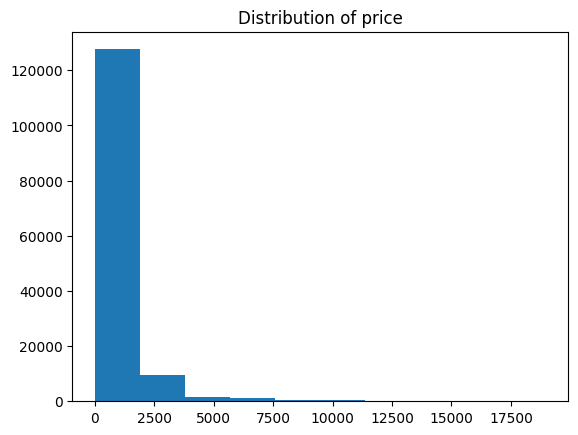

In [11]:
make_histogram('price')

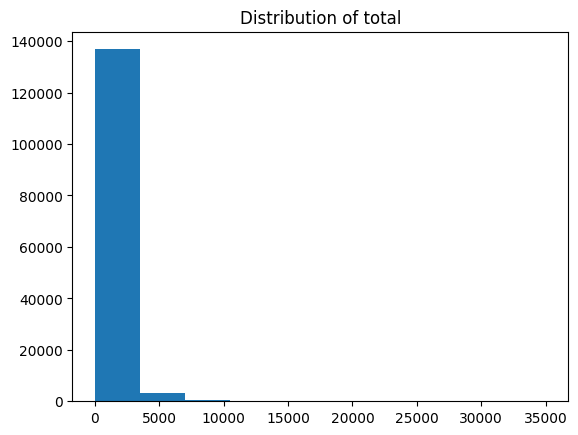

In [12]:
make_histogram('total')

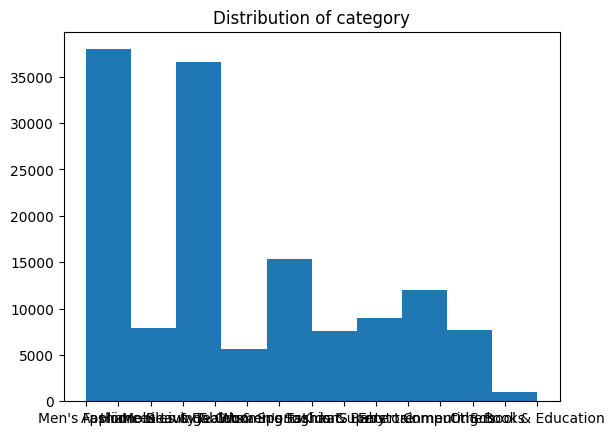

In [13]:
make_histogram("category")

# 4. Encoding

## Nolan Functions

In [14]:
def binary_label_encoding(data, column_name):
    unique_values = list(set(data[column_name]))
    map_value = {unique_values[i] : i for i in range(len(unique_values))}
    data[column_name] = list(map(lambda x : map_value[x], data[column_name]))
    return data

def label_encoding(data, column, values):
    map_values = {values[len(values)-i-1] : i for i in range(len(values)-1, -1, -1)}
    data[column] = list(map(lambda x : map_values[x], data[column]))
    return data

def target_encoding(data, column):
  count_unique = Counter(data[column])
  total = len(data[column])
  df[column] = list(map(lambda x : count_unique[x]/total, df[column]))
  return df

def geoencoding(data):
  lat = []
  lng = []
  drop_rows = []
  count = 0
  zip_list = list(data['Zip'])
  for i in range(len(zip_list)):
    zip_code = zip_list[i]
    if zip_code not in zip_dict:
      drop_rows.append(i)
      continue
    lat_lng = zip_dict[zip_code]

    lat.append(lat_lng[0])
    lng.append(lat_lng[1])
  data = data.drop(drop_rows)
  data = data.reset_index(drop=True)
  data['LAT'] = lat
  data['LNG'] = lng
  return data

## Main

In [15]:
binary_data_columns = ['Gender']
for column_name in binary_data_columns:
    df = binary_label_encoding(df, column_name)

In [16]:
nominal_columns = ["category", "Region"]
# Apply one hot encoding to our dataset for the nominal categorical features
for col in nominal_columns:
    df = pd.get_dummies(df, columns=[col], dtype=int)

In [17]:
target_columns = ["County", "City", "State"]
for t in target_columns:
  df = target_encoding(df, t)

In [18]:
df = geoencoding(df)

# 5. PCA

## Main

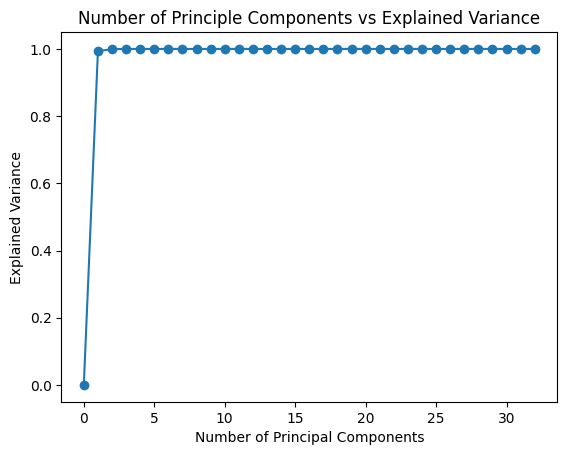

In [19]:
variance_pca = []
number_attributes = len(df.columns)
pca = PCA(n_components=number_attributes)
pca.fit(df)
explained_variance = pca.explained_variance_ratio_
for i in range(1, number_attributes):
    variance_list = list(explained_variance)[:i]
    variance_pca.append(sum(variance_list))
plt.plot([i for i in range(0, number_attributes)], [0] + variance_pca, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance")
plt.title("Number of Principle Components vs Explained Variance")
plt.show()

# 6. Clustering

In [21]:
def reverse_one_hot(df, features, name, categories):
    df_cat = df.loc[:, ["{}_{}".format(name, i) for i in categories]]
    n = range(len(categories))
    mapping = dict(list(zip(tuple([tuple([int(i == j) for i in n]) for j in n]), categories)))
    return pd.concat([df.loc[:, features], df_cat.index.to_series(name = name).map(lambda i: mapping[tuple(df_cat.loc[i, :])])], axis=1)

In [22]:
categories = ["Men's Fashion", 'Mobiles & Tablets', 'Computing', 'Appliances',
       'Home & Living', "Women's Fashion", 'Health & Sports',
       'Beauty & Grooming', 'Superstore', 'Others', 'Entertainment',
       'Soghaat', 'Kids & Baby', 'Books', 'School & Education']
mydf = reverse_one_hot(df, ["LAT", "LNG", "total"], "category", categories)
mydf

,LAT,LNG,total,category
0,34.924584,-99.867360,1798.0,Men's Fashion
1,34.924584,-99.867360,190.0,Men's Fashion
2,34.924584,-99.867360,1199.2,Men's Fashion
3,34.924584,-99.867360,639.2,Men's Fashion
4,34.924584,-99.867360,99.9,Men's Fashion
...,...,...,...,...
136907,36.931166,-76.239720,168.5,Appliances
136908,36.931166,-76.239720,1284.2,Computing
136909,62.908130,-160.066750,25.0,Women's Fashion
136910,42.325364,-89.170527,200.0,Books


In [27]:
def makeClusters(df, features, k, plot = None):
    X = df[features]
    model = KMeans(n_clusters=k, n_init="auto").fit(X)
    Y = pd.concat([df, pd.Series(data=model.predict(X), name = "Cluster")], axis = 1)
    if plot is None:
        return Y, model
    else:
        colors = np.linspace(0, 1, k)
        colordict = dict(zip(range(k), colors))
        Y["Color"] = Y["Cluster"].map(colordict)
        plt.scatter(x = Y[features[0]], y = X[features[1]], c = Y["Color"])
        plt.xlabel(plot[0])
        plt.ylabel(plot[1])
        plt.title("Data in {} Clusters".format(k))
        plt.show()

In [52]:
def weight_df(sales, store_loc, k):
    sales_df, model = makeClusters(sales, ["LNG", "LAT"], k)
    test_df = pd.DataFrame(dict(list(zip(["LNG", "LAT"], [[i] for i in store_loc]))))
    store_clusters = pd.Series(data = model.predict(test_df), name = "Cluster")
    cluster_df = sales_df.loc[lambda df: df["Cluster"] == store_clusters[0]].drop(columns = ["Cluster"])
    dist_weight = lambda i: 1/np.sqrt(2 * np.pi) * np.exp((-(np.linalg.norm(cluster_df.loc[i, ["LNG", "LAT"]] - test_df.loc[0, ["LNG", "LAT"]])) ** 2)/2)
    cluster_df["Weight"] = cluster_df.index.map(lambda i: dist_weight(i) * cluster_df.loc[i, "total"])
    category_series = cluster_df[["category", "Weight"]].groupby(by=["category"]).sum()["Weight"]
    print(category_series)
    total_weight = sum(category_series)
    return category_series.map(lambda w: w / total_weight)

In [53]:
location = [-99.867360, 34.924584]
weight_df(mydf, location, 20)


category
Appliances            16150.277579
Beauty & Grooming      1348.625682
Books                     2.110758
Computing              1417.708036
Entertainment         18040.077975
Health & Sports        1349.123281
Home & Living           519.675372
Kids & Baby             189.285320
Men's Fashion          4925.053792
Mobiles & Tablets     23949.666294
Others                 3274.599789
School & Education      341.515538
Soghaat                  18.345859
Superstore             1883.662483
Women's Fashion        2842.168188
Name: Weight, dtype: float64


category
Appliances            0.211802
Beauty & Grooming     0.017686
Books                 0.000028
Computing             0.018592
Entertainment         0.236585
Health & Sports       0.017693
Home & Living         0.006815
Kids & Baby           0.002482
Men's Fashion         0.064589
Mobiles & Tablets     0.314086
Others                0.042945
School & Education    0.004479
Soghaat               0.000241
Superstore            0.024703
Women's Fashion       0.037273
Name: Weight, dtype: float64